# Testing CircuitQ

In [1]:
import circuitq as cq
import os
import numpy as np
import networkx as nx
import scqubits as sc
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use({'figure.facecolor':'white'})

## Tim's 4-body coupler ([ArXiv Version](https://arxiv.org/pdf/1912.03322.pdf))

## Tim's Code

In [2]:
""" Simulate circuit C from automated discovery results """
import numpy.linalg
import scipy as sp
import scipy.sparse.linalg
import qutip as qt
import csv

# Identity
def I(n):
    return qt.qeye(2*n+1)

# Charge operator
def Q(n):
    return qt.Qobj( np.diag(np.arange(-n,n+1)) )

# Displacement operator D^+
def Dp(n, k=1):
    if 2*n+1-k > 0:
        d = np.ones(2*n+1-k)
        return qt.Qobj( np.diag(d, k=-k) )
    else:
        return qt.Qobj( np.zeros((2*n+1, 2*n+1)) )

# Displacement operator D^-
def Dm(n, k=1):
    return Dp(n, k).trans()

# phi^2 in terms of displacement operators
def Phi_sq(n):
    Phi_sq = 0
    for k in range(1, 2*n+1):
        Phi_sq += (-1)**k / k**2 * ( Dm(n,k) + Dp(n,k) )
    Phi_sq = 2 * Phi_sq
    return Phi_sq


def spec_circuitC(Carr, L13, L23, lj12, lj22, lj33, phiExt=[[0.0,0.5]], normalized=False, trunc=[6,6,8]):

    # Initialize spectrum
    spec = []

    # Calculate spectrum for swept parameter
    for p in phiExt:
        spec.append( eigs_circuitC(Carr, L13, L23, lj12, lj22, lj33, phiExt_fix=p, trunc=trunc) )
    spec = np.array(spec)

    # Normalize spectrum by ground state if desired
    if normalized:
        e0 = np.array([spec[i][0] for i in range(len(spec))])
        spec = (spec.T - e0).T

    return spec


def eigs_circuitC(Carr, L13, L23, lj12, lj22, lj33, phiExt_fix=[0.0,0.5], trunc=[6,6,8]):

    # Initialization
    n1 = trunc[0]  #node 1 states (oscillator)
    n2 = trunc[1]  #node 2 states (oscillator)
    n3 = trunc[2]  #node 3 states (charge)
    N  = 3  #number of nodes

    # Parameters and fundamental constants
    Jc      = 5e-6                   #critical current density in A/um^2
    wJ      = 0.2                    #junction width in um
    Sc      = 60e-15                 #specific capacitance in F/um^2
    e       = 1.60217662 * 10**(-19) #elementary charge
    h       = 6.62607004 * 10**(-34) #Planck constant
    hbar    = h/(2*np.pi)            #reduced Planck constant
    Phi0    = 2.06783385 * 10**(-15) #flux quantum
    Carr    = Carr * 1e-15           #scale fF -> F
    L13     = L13 * 1e-12            #scale pH -> H
    L23     = L23 * 1e-12            #scale pH -> H
    phi_var = phiExt_fix[0]
    phi_fix = phiExt_fix[1]

    # Calculate juction energies in GHz
    Ej12 = Phi0/(2*np.pi) * Jc*wJ*lj12 * 1/h/1e9
    Ej22 = Phi0/(2*np.pi) * Jc*wJ*lj22 * 1/h/1e9
    Ej33 = Phi0/(2*np.pi) * Jc*wJ*lj33 * 1/h/1e9

    # Construct capacitance connectivity matrix
    Carr += np.array([0, Sc*wJ*lj12, 0, Sc*wJ*lj22, 0, Sc*wJ*lj33]) #!!1e15
    Cmat, Jmat = np.zeros((N,N)), np.zeros((N,N))
    Cmat[np.triu_indices(N,k=0)] = Carr
    Cmat = np.maximum(Cmat, Cmat.transpose())

    # Maxwell capacitance matrix C (not confused with Capacitance connectivity matrix Cmat)
    C = np.diag(np.sum(Cmat, axis=0)) + np.diag(np.diag(Cmat)) - Cmat
    Cinv = sp.linalg.inv(C)
    #print(Cinv*1e-15)

    # Rotation to decouple the oscillator and Josephson terms of H
    R = np.array([[1,0,1],[0,1,1],[1,1,1]])
    Rinv = np.array([[0, -1, 1], [-1, 0, 1], [1, 1, -1]])
    Cinv = Rinv.dot(Cinv.dot(Rinv))
    #print(Rinv.dot(R))


    # Define operators for node 1,2 (oscillator modes)
    I1     = qt.qeye(n1)
    a1     = qt.destroy(n1)
    adag1  = qt.create(n1)
    adaga1 = qt.num(n1)
    I2     = qt.qeye(n2)
    a2     = qt.destroy(n2)
    adag2  = qt.create(n2)
    adaga2 = qt.num(n2)

    # Define operators for node 3 (charge mode)
    I3 = I(n3)
    Q3 = Q(n3)
    Dp3 = Dp(n3)
    Dm3 = Dm(n3)

    ### Oscillator Hamiltonian (in GHz) ###
    # Initialization of harmonic oscillator parameters and derived operators
    #-- mode 1 --
    f1     = np.sqrt(Cinv[0,0]/L23) / (2*np.pi) / 1.e9 #frequency of oscillator in GHz
    Z1     = np.sqrt(Cinv[0,0]*L23)                   #impedance of oscillator
    alpha1 = 2.*np.pi/Phi0 * np.sqrt(h*Z1/(4.*np.pi))   #displacement parameter
    Do1    = qt.displace(n1, 1.j*alpha1)                  #quantum optical displacement operator
    #-- mode 2 --
    f2     = np.sqrt(Cinv[1,1]/L13) / (2.*np.pi) / 1.e9 #frequency of oscillator in GHz
    Z2     = np.sqrt(Cinv[1,1]*L13)                   #impedance of oscillator
    alpha2 = 2.*np.pi/Phi0 * np.sqrt(h*Z2/(4.*np.pi))   #displacement parameter
    Do2    = qt.displace(n2, 1.j*alpha2)                  #quantum optical displacement operator
    # Assemble oscillator Hamiltonian
    Ho = f1 * qt.tensor(adaga1, I2, I3) + f2 * qt.tensor(I1, adaga2, I3)                     \
         - Cinv[0,1]/(4.*np.pi*np.sqrt(Z1*Z2)) / 1.e9 * qt.tensor(a1-adag1, a2-adag2, I3) \
         - 1.0*Ej12/2. * ( np.exp(2.*np.pi*1.j*phi_var) * qt.tensor(Do1.dag(), Do2.dag(), I3) + \
                      np.exp(-2.*np.pi*1.j*phi_var) * qt.tensor(Do1, Do2, I3) )

    ### Josephson Hamiltonian (in GHz) ###
    Hj = 1.0*Cinv[2,2]/2. * (2.*e)**2 / h / 1.e9 * qt.tensor(I1, I2, Q3**2)

    ### Interaction Hamiltonian ###
    Hint = -1.j * Cinv[0,2]/np.sqrt(4.*np.pi*Z1*h) / 1.e9 * (2.*e) * qt.tensor(a1-adag1, I2, Q3) \
           -1.j * Cinv[1,2]/np.sqrt(4.*np.pi*Z2*h) / 1.e9 * (2.*e) * qt.tensor(I1, a2-adag2, Q3) \
           -1.0*Ej22/2. * ( np.exp(-2.*np.pi*1.j*phi_fix) * qt.tensor(I1, Do2.dag(), Dm3)        \
                            + np.exp(2.*np.pi*1.j*phi_fix) * qt.tensor(I1, Do2, Dp3) )           \
           -1.0*Ej33/2. * ( np.exp(0.) * qt.tensor(Do1.dag(), Do2.dag(), Dm3)                    \
                            + np.exp(0.) * qt.tensor(Do1, Do2, Dp3) )

    # Assemble full Hamiltonian
    H = 1.0*Ho + 1.0*Hj + 1.0*Hint

    # print('H.dims:', H.dims)
    # print('H.isherm:', H.isherm)
    print('*', end='')

    print("starting calculating evals")
    evals, state = H.tidyup().eigenstates(eigvals=5, sparse=True)
    print("done calculating evals")
    
    # # Visualize eigenstate state population
    # #print(abs(state[0].full().T[0]))
    # plt.figure()
    # for s in state:
    # 	plt.plot(abs(s.full().T[0]))
    # plt.show()

    return evals

# Qubit parameters (Jc, Sc defined in function above)
Carr = np.array([0., 0., 85.677, 4.455, 16.832, 70.556]) #in fF #np.array([0., 0., 98.847, 14.99, 38.666, 67.457])
L13  = 289.395  #in pH #293.268
L23  = 120.416  #in pH #98.07
lj12 = 3.75498  #in um #3.7549
lj22 = 0.395517 #in um #0.376366
lj33 = 0.373288 #in um #0.386997

# Truncation setting
trunc = [12,12,12 ] #[6,6,8] #[12,12,12]

# Single flux at operating point
evals = spec_circuitC(Carr, L13, L23, lj12, lj22, lj33, trunc=trunc)
print('Normalized eigen-energies at operating point (in GHz):', evals[0]-evals[0,0])
print("Input", Carr, L13, L23, lj12, lj22, lj33)

# # Effect of truncation
# xdata = np.arange(6,15,1)
# ydata = []
# for p in xdata:
# 	trunc = [p,p,10]
# 	evals = spec_circuitC(Carr, L13, L23, lj12, lj22, lj33, trunc=trunc)
# 	ydata.append( evals[0,1]-evals[0,0] )
# plt.figure()
# plt.plot(xdata, ydata)
# plt.show()

# Spectrum
phiVar = np.linspace(0.0-1*0.025, 0.0+1*0.025, 5, endpoint=True)
# phiVar = np.linspace(0.0-0.5, 0.0+0.5, 21, endpoint=True)
phiExt = [[p, 0.5] for p in phiVar]
spec = spec_circuitC(Carr, L13, L23, lj12, lj22, lj33, phiExt=phiExt, trunc=trunc)


*starting calculating evals
done calculating evals
Normalized eigen-energies at operating point (in GHz): [ 0.          0.87940876  3.99130996  6.89864933 10.23719534]
Input [ 0.     0.    85.677  4.455 16.832 70.556] 289.395 120.416 3.75498 0.395517 0.373288
*starting calculating evals
done calculating evals
*starting calculating evals
done calculating evals
*starting calculating evals
done calculating evals
*starting calculating evals
done calculating evals
*starting calculating evals
done calculating evals


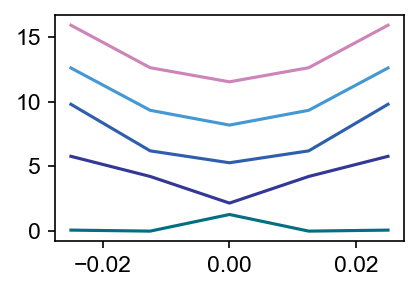

In [45]:
plt.figure(figsize=(3,2))
plt.plot(phiVar, spec[:,:5]-np.min(spec))
plt.show()

In [46]:
spec

array([[-1844.98437698, -1839.29068851, -1835.2746272 , -1832.47302609,
        -1829.17318398],
       [-1845.06202656, -1840.84359636, -1838.86858267, -1835.73811434,
        -1832.45329447],
       [-1843.778482  , -1842.89907324, -1839.78717204, -1836.87983267,
        -1833.54128666],
       [-1845.06202656, -1840.84359636, -1838.86858267, -1835.73811434,
        -1832.45329447],
       [-1844.98437698, -1839.29068851, -1835.2746272 , -1832.47302609,
        -1829.17318398]])

## Compare
### Determine parameter values

In [4]:
# Qubit parameters 
Carr = np.array([0., 0., 85.677, 4.455, 16.832, 70.556]) #in fF 
L13  = 289.395  #in pH 
L23  = 120.416  #in pH 
lj12 = 3.75498  #in um 
lj22 = 0.395517 #in um 
lj33 = 0.373288 #in um 

# Parameters and fundamental constants
N       = 3                      #number of nodes
Jc      = 5e-6                   #critical current density in A/um^2
wJ      = 0.2                    #junction width in um
Sc      = 60e-15                 #specific capacitance in F/um^2
e       = 1.60217662 * 10**(-19) #elementary charge
h       = 6.62607004 * 10**(-34) #Planck constant
hbar    = h/(2*np.pi)            #reduced Planck constant
Phi0    = 2.06783385 * 10**(-15) #flux quantum
Carr    = Carr * 1e-15           #scale fF -> F
L13     = L13 * 1e-12            #scale pH -> H
L23     = L23 * 1e-12            #scale pH -> H

# Calculate juction energies in Hz
Ej12 = Phi0/(2*np.pi) * Jc*wJ*lj12 
Ej22 = Phi0/(2*np.pi) * Jc*wJ*lj22 
Ej33 = Phi0/(2*np.pi) * Jc*wJ*lj33

# Construct capacitance connectivity matrix
Carr += np.array([0, Sc*wJ*lj12, 0, Sc*wJ*lj22, 0, Sc*wJ*lj33]) #!!1e15


## Create CircuitQ instance

In [23]:
graph = nx.MultiGraph()
graph.add_edge(0,2, element = 'C')
graph.add_edge(0,2, element = 'J')
graph.add_edge(2,3, element = 'L')
graph.add_edge(2,3, element = 'C')
graph.add_edge(0,3, element = 'C')
graph.add_edge(0,3, element = 'J')
graph.add_edge(2,1, element = 'C')
graph.add_edge(2,1, element = 'J')
graph.add_edge(1,3, element = 'L')
graph.add_edge(1,3, element = 'C')

main_dir = os.path.abspath('..')
figure_path = os.path.join(main_dir, 'figures/4_body_coupler/circuit')
cq.visualize_circuit_general(graph,figure_path)

circuit = cq.CircuitQ(graph, ground_nodes=[0])
circuit.h_parameters

[C_{02},
 C_{03},
 C_{21},
 C_{23},
 C_{31},
 E_{J020},
 E_{J030},
 E_{J210},
 L_{230},
 L_{310},
 \tilde{\Phi}_{230},
 \tilde{\Phi}_{310}]

### Loop over external flux

In [24]:
# eigv_list = []
# phi_ex_list = np.linspace(-0.025*circuit.phi_0, 0.025*circuit.phi_0, 5, endpoint=True)
# for phi_ex in tqdm(phi_ex_list):
#     circuit = cq.CircuitQ(graph, ground_nodes=[0])
#     print(circuit.h_parameters)
#     circuit.get_numerical_hamiltonian(30, 
#     parameter_values=[4.455*1e-15+Sc*wJ*lj22, 70.556*1e-15+Sc*wJ*lj33, Sc*wJ*lj12, 16.832*1e-15, 85.677*1e-15,   
#                      Ej22, Ej33, Ej12, L23, L13, 0.5*circuit.phi_0, phi_ex])
#     eigv, eigs = circuit.get_eigensystem(30)
#     eigv_list.append(eigv)
#     print(eigv)   

In [25]:
# eigv_list = np.array(eigv_list)
# plt.figure(figsize=(3,2))
# plt.plot(phi_ex_list/(circuit.phi_0), eigv_list[:,:30]-np.min(eigv_list))
# plt.show()

In [26]:
# circuit.h_imp

In [27]:
# circuit.loop_fluxes

### Eigenvalues as a function of dimension

#### Calculating Tims reference energies

In [28]:
# Qubit parameters (Jc, Sc defined in function above)
Carr = np.array([0., 0., 85.677, 4.455, 16.832, 70.556]) #in fF #np.array([0., 0., 98.847, 14.99, 38.666, 67.457])
L13  = 289.395  #in pH #293.268
L23  = 120.416  #in pH #98.07
lj12 = 3.75498  #in um #3.7549
lj22 = 0.395517 #in um #0.376366
lj33 = 0.373288 #in um #0.386997

# Truncation setting
trunc = [12,12,12 ] #[6,6,8] #[12,12,12]

In [29]:
evals_tim = spec_circuitC(Carr, L13, L23, lj12, lj22, lj33,  phiExt=[[0.02,0.5]], trunc=trunc)

*starting calculating evals
done calculating evals


#### Calculating CircuitQ reference energies

In [30]:
# Parameters and fundamental constants
N       = 3                      #number of nodes
Jc      = 5e-6                   #critical current density in A/um^2
wJ      = 0.2                    #junction width in um
Sc      = 60e-15                 #specific capacitance in F/um^2
e       = 1.60217662 * 10**(-19) #elementary charge
h       = 6.62607004 * 10**(-34) #Planck constant
hbar    = h/(2*np.pi)            #reduced Planck constant
Phi0    = 2.06783385 * 10**(-15) #flux quantum
Carr    = Carr * 1e-15           #scale fF -> F
L13     = L13 * 1e-12            #scale pH -> H
L23     = L23 * 1e-12            #scale pH -> H

# Calculate juction energies in Hz
Ej12 = Phi0/(2*np.pi) * Jc*wJ*lj12 
Ej22 = Phi0/(2*np.pi) * Jc*wJ*lj22 
Ej33 = Phi0/(2*np.pi) * Jc*wJ*lj33


In [31]:
eigv_list = []
dim_list = np.array([10, 20, 30])# 50, 60, 70, 80])
for dim in dim_list:
    circuit = cq.CircuitQ(graph, ground_nodes=[0])
    print("Dimension", dim)
    circuit.get_numerical_hamiltonian(dim, 
    parameter_values=[4.455*1e-15+Sc*wJ*lj22, 70.556*1e-15+Sc*wJ*lj33, Sc*wJ*lj12, 16.832*1e-15, 85.677*1e-15,   
                     Ej22, Ej33, Ej12, L23, L13, 0.5*circuit.phi_0, 0.02*circuit.phi_0])
    eigv, eigs = circuit.get_eigensystem(10)
    eigv_list.append(eigv)

Dimension 10
Dimension 20
Dimension 30
Dimension 50


(-5e-24, 1e-22)

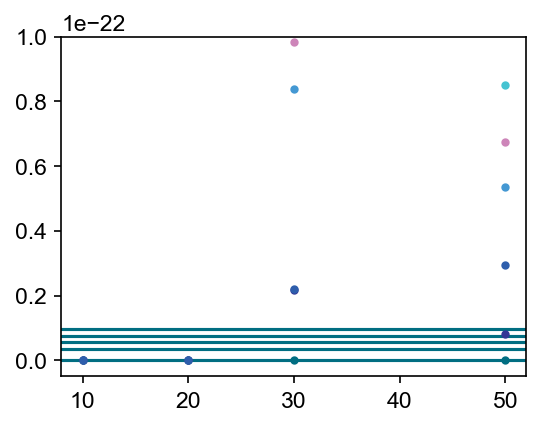

In [40]:
plt.figure(figsize=(4,3))
#plt.plot(dim_list, h*(evals_tim-np.min(evals_tim))*10**9 , '-')
evals_tim_scaled = h*(evals_tim[0]-np.min(evals_tim[0]))*1e9
for ev in evals_tim_scaled:
    plt.axhline(y=ev)
eigv_list_scaled = [eigvs - np.min(eigvs) for eigvs in eigv_list]
plt.plot(dim_list, eigv_list_scaled, '.')
plt.ylim(-0.05e-22,1e-22)

In [33]:
differences_dim = []
for n, dim in enumerate(dim_list):
    differences = []
    for l, eigv in enumerate(eigv_list_scaled[n]):
        if l>4:
            break
        differences.append(abs(eigv - evals_tim_scaled[l]))
    differences_dim.append(sum(differences))    

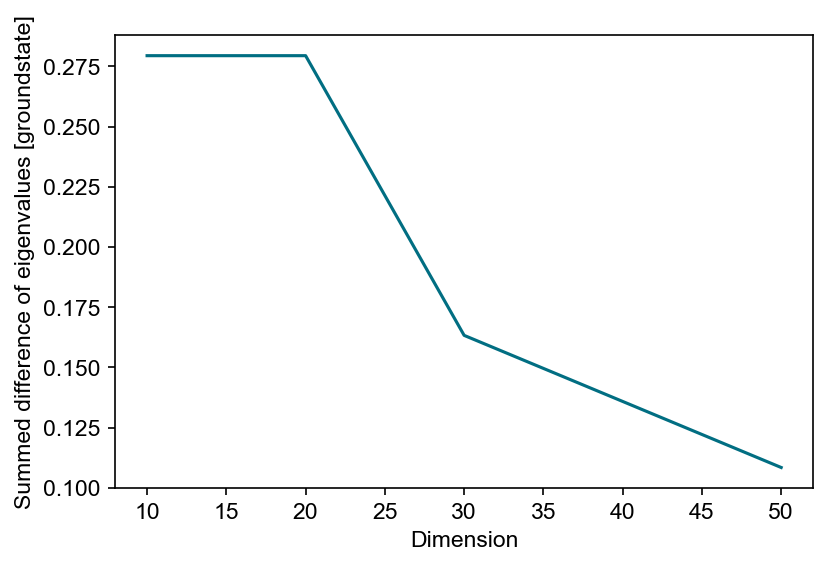

In [34]:
plt.plot(dim_list, np.array(differences_dim)/(abs(h*evals_tim[0][0]*1e9)) )
plt.xlabel("Dimension")
plt.ylabel(r"Summed difference of eigenvalues [groundstate]")
plt.show()

In [35]:
evals_tim

array([[-1845.23484281, -1839.96817368, -1836.83051225, -1834.07185396,
        -1830.74046802]])

In [36]:
evals_tim_scaled

array([0.00000000e+00, 3.48973185e-24, 5.56876829e-24, 7.39667460e-24,
       9.60407426e-24])

In [43]:
1839/1845

0.9967479674796748

In [38]:
[eigvs - np.min(eigvs) for eigvs in eigv_list]

[array([0.00000000e+00, 2.24790466e-29, 2.53387894e-29, 1.74831348e-22,
        1.74831348e-22, 1.74831371e-22, 1.74831371e-22, 4.57714441e-22,
        4.57714441e-22, 4.57714441e-22]),
 array([0.00000000e+00, 1.30338814e-34, 1.18349598e-27, 1.74831182e-22,
        1.74831182e-22, 1.74831226e-22, 1.74831226e-22, 1.74831226e-22,
        4.57713351e-22, 4.57714074e-22]),
 array([0.00000000e+00, 2.18441549e-23, 2.18692988e-23, 8.36864224e-23,
        9.83618253e-23, 1.19566162e-22, 1.72471360e-22, 1.74964466e-22,
        2.60850808e-22, 2.79499934e-22]),
 array([0.00000000e+00, 8.18515194e-24, 2.93544384e-23, 5.35883213e-23,
        6.75500473e-23, 8.50312381e-23, 1.11203786e-22, 1.68794499e-22,
        1.70602011e-22, 1.73204792e-22])]